# Bayes models
#### Transformation model based variational inference (TM-VI)
#### Image data: CIb model , compare MF-Gaussian-VI with MF-TM-VI (last layer FCNN)

In [2]:
# packages

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import seaborn as sns
from numpy.random import seed
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
from tensorflow.keras import layers
from functions.scoreCI import score_ci
from tensorflow.keras import regularizers
%load_ext autoreload
%autoreload 2
import glob
from functions.vimlts import VimltsLinear,DenseViGauss 
from functions.sample_bernoulli_nll import sample_bernoulli_nll
from functions.logScore import logScore

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available:  1


In [11]:
## add resize images and add path to patient
dat = pd.read_csv('../thesis/patientData.csv')
train_dir = "../thesis/trainRes/"
dat['path'] = train_dir + dat.image_name + ".jpg"


In [12]:
np.random.seed(3004)
idx = np.arange(len(dat))
np.random.shuffle(idx)


train_idx = idx[:int(len(dat)*0.8)] # 80% training
test_idx = idx[int(len(dat)*0.8):] # 20% test
valid_idx = train_idx[:int(len(train_idx)*0.2)] # 20% of training as validation
train_idx = train_idx[int(len(train_idx)*0.2):]
print(train_idx.shape, valid_idx.shape, test_idx.shape)

(21200,) (5300,) (6626,)


In [13]:
X_train = dat.iloc[train_idx]
X_valid= dat.iloc[valid_idx]
X_test= dat.iloc[test_idx]
print(X_train.shape, X_valid.shape, X_test.shape)

(21200, 9) (5300, 9) (6626, 9)


In [14]:
y_train = dat.iloc[train_idx]
y_train = y_train.loc[:, y_train.columns.intersection(['target'])]
y_valid= dat.iloc[valid_idx]
y_valid = y_valid.loc[:, y_train.columns.intersection(['target'])]
y_test= dat.iloc[test_idx]
y_test = y_test.loc[:, y_train.columns.intersection(['target'])]
print(y_train.shape, y_valid.shape, y_test.shape)

(21200, 1) (5300, 1) (6626, 1)


In [15]:
# save image path
train_files = X_train.path
val_files = X_valid.path
test_files = X_test.path

# img_to_array image als array transformieren
train_imgs = [img_to_array(load_img(img)) for img in train_files]
validation_imgs = [img_to_array(load_img(img)) for img in val_files]
test_imgs = [img_to_array(load_img(img)) for img in test_files]

train_imgs = np.array(train_imgs)
train_labels = y_train

validation_imgs = np.array(validation_imgs)
val_labels = y_valid
#
test_imgs = np.array(test_imgs)
test_labels = y_test


print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape,
     '\Test dataset shape:', test_imgs.shape)

Train dataset shape: (21200, 128, 128, 3) 	Validation dataset shape: (5300, 128, 128, 3) \Test dataset shape: (6626, 128, 128, 3)


In [16]:
#scale pixel zwischen 0 und 1

train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled  = test_imgs.astype('float32')
train_labels = train_labels.astype("float32")
val_labels = val_labels.astype("float32")
val_labels = val_labels.astype("float32")
train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

#plt.imshow(train_imgs_scaled[0])


### OOD and augmentation data

In [18]:
## random images 
filelist = glob.glob('./oodImages/*.npy')
x = [np.array(np.load(fname)) for fname in filelist]
randomX = np.asarray(x)
oodRandom = randomX.reshape(17,128,128,3)
oodRandom.shape

(17, 128, 128, 3)

In [19]:
## augmentation images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(factor=0.9, fill_mode="wrap"),
  layers.experimental.preprocessing.RandomTranslation(height_factor=1, width_factor=1, fill_mode="reflect"),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
])
# Add the image to a batch
image= test_imgs_scaled[300:403] 
augmented_image = data_augmentation(image)
bright = tf.image.adjust_brightness(augmented_image, 0.2) ##add additionaly brightness 
bright.shape
#plt.imshow(bright[10])
#plt.axis("off")

TensorShape([103, 128, 128, 3])

### Functions

In [20]:
def softplus_inv(y):
    return np.log(np.exp(y) - 1)



#combine two components
def modelOn(X):
    added = X.layers[14].output   ## before sigmoid to obtain eta(B)
    out = tf.math.sigmoid(added)
    model1 = keras.Model(inputs = X.input, outputs = out, name='model_XXX')
    return model1 
    
prior_dist=tfd.Normal(loc=0.,scale=1.)

## Gauß-VI last-layer eta Bild

In [18]:
## Complex shift image
from tensorflow.keras import regularizers

    
in_ = keras.Input(shape = (128,128,3), name = "inImg")
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(in_)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01), ##numerical stability
                activity_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
out= DenseViGauss(units=1,
                      size= train_imgs_scaled.shape[0],
                      activation=tf.keras.activations.linear,
                      num_samples=1000,     
                      prior_dist=prior_dist)(x)

nn_imG = keras.Model (inputs = in_, outputs = out)
nn_imG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inImg (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0     

In [13]:

nn_image = modelOn(nn_imG)
nn_image.compile(optimizer=Adam(1e-4), loss=sample_bernoulli_nll, run_eagerly=False)  ##adamle-5

#### Train model

In [ ]:
nn_image.compile(optimizer=Adam(1e-4), loss=sample_bernoulli_nll, run_eagerly=False)  ##adamle-5
results = nn_image.fit(x = train_imgs_scaled, 
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=256,
                        epochs = 100,
                        verbose= True)    

In [15]:
# save results
#dat = pd.DataFrame({'train_loss': results.history['loss'], 
 #                      'test_loss': results.history['val_loss']})
#dat.to_csv('../thesis/performance/gaussVI/history.csv', index=False)

### save model weights whole model
#nn_image.save_weights("../thesis/models/CNNGaus", save_format ="tf")
### save model weights eta
#nn_imG.save_weights("../thesis/models/CNNGaussEta", save_format ="tf")


#### Load model weights

In [14]:
### recreate Model eta
nn_imG.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_imG.load_weights("../thesis/models/CNNGaussEta")

### recreate whole Model
nn_image.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_image.load_weights("../thesis/models/CNNGaus")

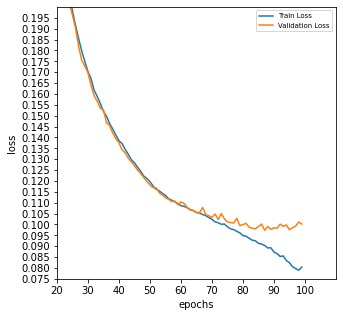

In [15]:

plt.figure(figsize=(5,5))
loss0 = pd.read_csv('../thesis/performance/gaussVI/history.csv')
plt.plot(loss0['train_loss'],label="Train Loss")
plt.plot(loss0['test_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.075,0.2)
plt.yticks(np.arange(0.075, 0.2, 0.005))
plt.xticks(np.arange(20, 110, 10))
plt.xlim(20,110)
plt.legend(fontsize='x-small')

## Performance

In [15]:
y_pred = nn_image.predict(test_imgs_scaled,batch_size =1)

samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)

2021-11-19 17:10:09.071107: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1302724608 exceeds 10% of free system memory.
2021-11-19 17:10:09.225977: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-19 17:10:09.244073: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz
2021-11-19 17:10:09.355831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-19 17:10:09.488580: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-19 17:10:10.406137: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-11-19 17:10:10.583515: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx 

In [16]:
logScore(test_labels,predictions)

-0.07690533584516547

In [19]:
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)

AUC=0.82, 95% CI: 0.79-0.86


### Prediction on OOD and testdata (ID) eta(B) 

In [89]:

##eta with random images
Gy_predTabOOD = nn_imG.predict(oodRandom,batch_size =1)
GsamplesImgOOD = Gy_predTabOOD.reshape(-1, 1000) ###every datapoint one sample
GmeanpredImgOOD = GsamplesImgOOD.mean(axis=1)  ###mean samples 
GpredictionsImgOOD=GmeanpredImgOOD.reshape(17,1)
## IQR Range
Gy_predictions_25ImgOOD=np.quantile(GsamplesImgOOD,0.25,axis=1)  
Gy_predictions_75IMGOOD=np.quantile(GsamplesImgOOD,0.75,axis=1)

##dataframe
GImgCenterOOD = [sublist[-1] for sublist in GpredictionsImgOOD]
GImgLowOOD = [sublist[-1] for sublist in Gy_predictions_25ImgOOD.reshape(17,1)]
GImgHighOOD = [sublist[-1] for sublist in Gy_predictions_75IMGOOD.reshape(17,1)]
##range of IQR
GImgwidthOOD= [x1 - x2 for (x1, x2) in zip(GImgHighOOD, GImgLowOOD)]

##eta augmented images
Gy_predTabOODA = nn_imG.predict(bright,batch_size =1)
GsamplesImgOODA = Gy_predTabOODA.reshape(-1, 1000) ###every datapoint one sample
GmeanpredImgOODA = GsamplesImgOODA.mean(axis=1)  ###mean samples 
GpredictionsImgOODA=GmeanpredImgOODA.reshape(103,1)
## IQR Range
Gy_predictions_25ImgOODA=np.quantile(GsamplesImgOODA,0.25,axis=1)
Gy_predictions_75IMGOODA=np.quantile(GsamplesImgOODA,0.75,axis=1)

##dataframe
GImgCenterOODA = [sublist[-1] for sublist in GpredictionsImgOODA]
GImgLowOODA = [sublist[-1] for sublist in Gy_predictions_25ImgOODA.reshape(103,1)]
GImgHighOODA = [sublist[-1] for sublist in Gy_predictions_75IMGOODA.reshape(103,1)]
##range of IQR
GImgwidthOODA= [x1 - x2 for (x1, x2) in zip(GImgHighOODA, GImgLowOODA)]

In [90]:
### Prediction on Testdata

Gy_pred = nn_imG.predict(test_imgs_scaled[0:120],batch_size =1)
Gsamples = Gy_pred.reshape(-1, 1000) ###every datapoint one sample
Gmeanpred = Gsamples.mean(axis=1)  ###mean samples 
Gpredictions=Gmeanpred.reshape(120,1)

Gy_predictions_25=np.quantile(Gsamples,0.25,axis=1)
Gy_predictions_75=np.quantile(Gsamples,0.75,axis=1)

GImgCenter = [sublist[-1] for sublist in Gmeanpred.reshape(120,1)]
GImgLow = [sublist[-1] for sublist in Gy_predictions_25.reshape(120,1)]
GImgHigh = [sublist[-1] for sublist in Gy_predictions_75.reshape(120,1)]
GImgwidth= [x1 - x2 for (x1, x2) in zip(GImgHigh, GImgLow)]

### Testdata
Gimagedata = pd.DataFrame(
    {'Gwidth': GImgwidth,
     'Gcenter': GImgCenter
    })

###Out of distribution

GimagadataOOD = pd.DataFrame(
    {'Gwidth': GImgwidthOOD,
     'Gcenter': GImgCenterOOD
    })

###Out of distribution

GimagadataOODA = pd.DataFrame(
    {'Gwidth': GImgwidthOODA,
     'Gcenter': GImgCenterOODA
    })

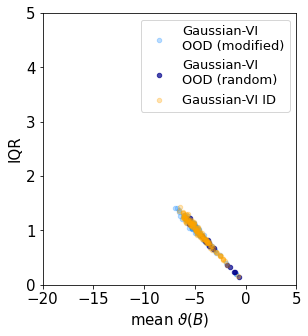

In [77]:
fig = plt.figure(figsize=(10,5))
plt.rcParams.update(({'font.size': 15}))
fig.add_subplot(121)
plt.scatter(GimagadataOODA["Gcenter"],GimagadataOODA["Gwidth"],label="Gaussian-VI\nOOD (modified)",s=20,alpha=0.3, color="dodgerblue")
plt.scatter(GimagadataOOD["Gcenter"],GimagadataOOD["Gwidth"],label="Gaussian-VI\nOOD (random)",s=20,alpha=0.7,color="darkblue")
plt.scatter(Gimagedata["Gcenter"],Gimagedata["Gwidth"],label="Gaussian-VI ID",alpha=0.3,s=20,color="orange")
plt.ylabel("IQR")
plt.xlabel("mean $\\vartheta(B)$")
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(-20, 10, 5))
plt.legend(fontsize=13)
#plt.savefig("./plots/uncertainty/imagegausTMVIcompare2.pdf")


## CNN Last layer TMVI

In [19]:

### Kein Bias Bei Linear Shift
M=50
theta_start = -3  ##Range Gauss-VI
theta_stop = 3
num_samples=1000


vimlts_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] +
                              [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])                 

In [20]:
in_ = keras.Input(shape = (128,128,3), name = "inImg")
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(in_)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
eta = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,    ###Linear
                      num_samples=num_samples,
                      size = train_imgs_scaled.shape[0],
                      **vimlts_initializers,
                      prior_dist=prior_dist)(x)
nn_im = keras.Model (inputs = in_, outputs = eta)
nn_im.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inImg (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 32)      896       
_____________________________________________________

In [36]:

nn_imageTMVI = modelOn(nn_im)
nn_imageTMVI.compile(optimizer=Adam(1e-5), loss=sample_bernoulli_nll, run_eagerly=False)  ##adamle-5

#### Train model

In [ ]:
results = nn_imageTMVI.fit(x = train_imgs_scaled, 
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=256,
                        epochs = 250, ##250
                        verbose= True)  

In [ ]:
# save results
#dat = pd.DataFrame({'train_loss': results.history['loss'], 
                     #   'test_loss': results.history['val_loss']})
#dat.to_csv('../thesis/performance/imageTMVI/history.csv', index=False)

#### save model weights only eta
#nn_im.save_weights("../thesis/models/CNNLastLayerTMVI", save_format ="tf")
#### save model weights whole model
#nn_imageTMVI.save_weights("../thesis/models/CNNLastLayerTMVIWhole", save_format ="tf")

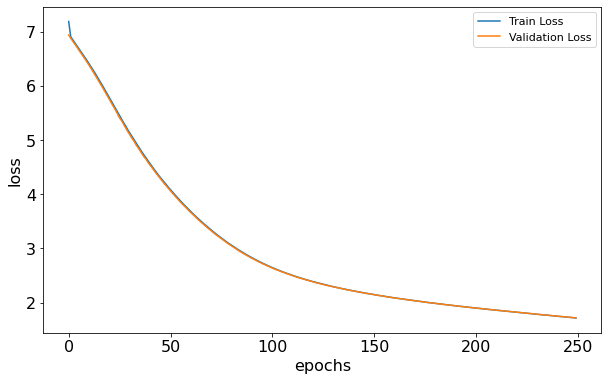

In [32]:
loss1 = pd.read_csv('../thesis/performance/imageTMVI/history.csv')
plt.figure(figsize=(10,6))
plt.rcParams.update(({'font.size': 16}))
plt.plot(loss1['train_loss'],label="Train Loss")
plt.plot(loss1['test_loss'], label="Validation Loss")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")


plt.legend(fontsize='x-small')
#plt.yscale('log')

In [38]:
### recreate Model eta
nn_im.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_im.load_weights("../thesis/models/CNNLastLayerTMVI")

### recreate whole Model
nn_imageTMVI.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
#nn_im.fit(x =train_imgs_scaled,y = train_labels, verbose=True)
### load the state of the old model
nn_imageTMVI.load_weights("../thesis/models/CNNLastLayerTMVIWhole")

## Performance

In [40]:
y_pred = nn_imageTMVI.predict(test_imgs_scaled,batch_size =1)
samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)

2021-11-19 12:13:17.948693: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1302724608 exceeds 10% of free system memory.


In [41]:
# logscore
logScore(test_labels,predictions)

-0.07636242000345499

In [42]:
# AUC
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)

AUC=0.83, 95% CI: 0.80-0.86


## Posterior for 1, 2 images

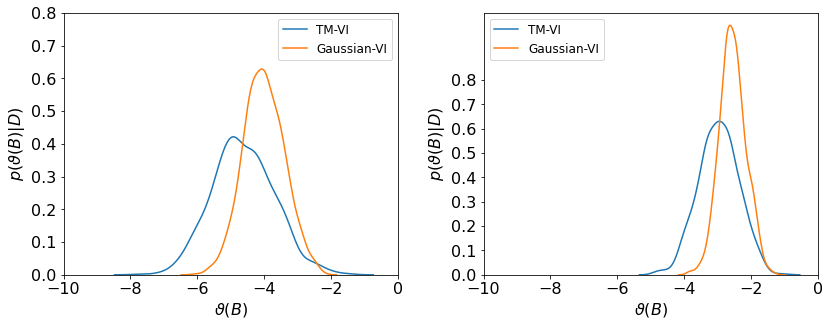

In [82]:
fig =plt.figure(figsize=(12,5))
plt.rcParams.update(({'font.size': 16}))
plt.subplot(121)
y_pred = nn_im.predict(test_imgs_scaled[8:9],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2,label="TM-VI")

y_pred = nn_imG.predict(test_imgs_scaled[8:9],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2, label="Gaussian-VI")
plt.yticks(np.arange(0, 0.9, 0.1))
plt.xticks(np.arange(-10, 2, 2))
plt.xlabel("$\\vartheta(B)$")
plt.ylabel("$p(\\vartheta(B)|D)$")

plt.legend(fontsize=12)
plt.subplot(122)
y_pred = nn_im.predict(test_imgs_scaled[7:8],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2,label="TM-VI")

y_pred = nn_imG.predict(test_imgs_scaled[7:8],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2, label="Gaussian-VI")
plt.xlabel("$\\vartheta(B)$")
plt.yticks(np.arange(0, 0.9, 0.1))
plt.xticks(np.arange(-10, 2, 2))
plt.ylabel("$p(\\vartheta(B)|D)$")
plt.legend(fontsize=12)
fig.tight_layout(pad=1.5)

#plt.savefig('./plots/uncertainty/imagePosteriorExamples.pdf')
# plt.show()

## OOD 

In [86]:
###eta
y_predTabOOD = nn_im.predict(oodRandom,batch_size =1)
samplesImgOOD = y_predTabOOD.reshape(-1, 1000) ###every datapoint one sample
meanpredImgOOD = samplesImgOOD.mean(axis=1)  ###mean samples 
predictionsImgOOD=meanpredImgOOD.reshape(17,1)
##IQR 
y_predictions_25ImgOOD=np.quantile(samplesImgOOD,0.25,axis=1)
y_predictions_75IMGOOD=np.quantile(samplesImgOOD,0.75,axis=1)


##dataframe
ImgCenterOOD = [sublist[-1] for sublist in predictionsImgOOD]
ImgLowOOD = [sublist[-1] for sublist in y_predictions_25ImgOOD.reshape(17,1)]
ImgHighOOD = [sublist[-1] for sublist in y_predictions_75IMGOOD.reshape(17,1)]
## IQR range
ImgwidthOOD= [x1 - x2 for (x1, x2) in zip(ImgHighOOD, ImgLowOOD)]


###eta
y_predTabOODA = nn_im.predict(bright,batch_size =1)
samplesImgOODA = y_predTabOODA.reshape(-1, 1000) ###every datapoint one sample
meanpredImgOODA = samplesImgOODA.mean(axis=1)  ###mean samples 
predictionsImgOODA=meanpredImgOODA.reshape(103,1)
##IQR 
y_predictions_25ImgOODA=np.quantile(samplesImgOODA,0.25,axis=1)
y_predictions_75IMGOODA=np.quantile(samplesImgOODA,0.75,axis=1)
##dataframe
ImgCenterOODA = [sublist[-1] for sublist in predictionsImgOODA]
ImgLowOODA = [sublist[-1] for sublist in y_predictions_25ImgOODA.reshape(103,1)]
ImgHighOODA = [sublist[-1] for sublist in y_predictions_75IMGOODA.reshape(103,1)]
##IQR range
ImgwidthOODA= [x1 - x2 for (x1, x2) in zip(ImgHighOODA, ImgLowOODA)]

In [87]:
###vorbereitung image


y_pred = nn_im.predict(test_imgs_scaled[0:120],batch_size =1)
samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(120,1)

y_predictions_25=np.quantile(samples,0.25,axis=1)
y_predictions_75=np.quantile(samples,0.75,axis=1)

ImgCenter = [sublist[-1] for sublist in meanpred.reshape(120,1)]
ImgLow = [sublist[-1] for sublist in y_predictions_25.reshape(120,1)]
ImgHigh = [sublist[-1] for sublist in y_predictions_75.reshape(120,1)]
Imgwidth= [x1 - x2 for (x1, x2) in zip(ImgHigh, ImgLow)]

imagedata = pd.DataFrame(
    {'width': Imgwidth,
     'center': ImgCenter
    })

###Out of distribution

imagadataOOD = pd.DataFrame(
    {'width': ImgwidthOOD,
     'center': ImgCenterOOD
    })

###Out of distribution

imagadataOODA = pd.DataFrame(
    {'width': ImgwidthOODA,
     'center': ImgCenterOODA
    })

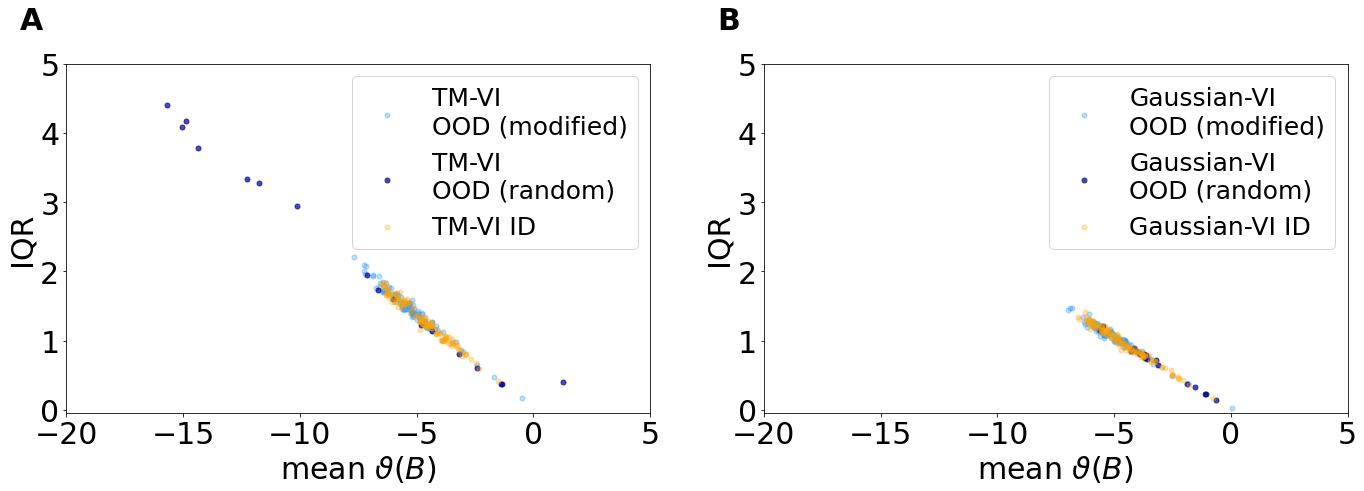

In [91]:
fig = plt.figure(figsize=(20,8))

plt.rcParams.update(({'font.size': 30}))



fig.add_subplot(121)
plt.scatter(imagadataOODA["center"],imagadataOODA["width"],alpha=0.3,s=25, label= "TM-VI\nOOD (modified)",color="dodgerblue")
plt.scatter(imagadataOOD["center"],imagadataOOD["width"],alpha=0.7,s=25, label= "TM-VI\nOOD (random)",color="darkblue")
plt.scatter(imagedata["center"],imagedata["width"],label="TM-VI ID",alpha=0.3,s=25,color="orange")
plt.text(-22, 5.5,"A", 
            size=30, weight='bold')
plt.ylabel("IQR")
plt.xlabel("mean $\\vartheta(B)$")
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(-20, 10, 5))
plt.legend(fontsize=25)



fig.add_subplot(122)
plt.scatter(GimagadataOODA["Gcenter"],GimagadataOODA["Gwidth"],label="Gaussian-VI\nOOD (modified)",s=25,alpha=0.3, color="dodgerblue")
plt.scatter(GimagadataOOD["Gcenter"],GimagadataOOD["Gwidth"],label="Gaussian-VI\nOOD (random)",s=25,alpha=0.7,color="darkblue")
plt.scatter(Gimagedata["Gcenter"],Gimagedata["Gwidth"],label="Gaussian-VI ID",alpha=0.3,s=25,color="orange")
plt.text(-22, 5.5,"B", 
            size=30, weight='bold')
plt.ylabel("IQR")
plt.xlabel("mean $\\vartheta(B)$")
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(-20, 10, 5))
plt.legend(fontsize=25)



fig.tight_layout(pad=1.5)

#plt.savefig("./plots/uncertainty/imagegausTMVIcompare1.pdf")

In [2]:
%reload_ext version_information
%version_information tensorflow,numpy, pandas, matplotlib

Software versions
Python 3.9.7 64bit [GCC 7.5.0]
IPython 7.27.0
OS Linux 5.8.0 63 generic x86_64 with glibc2.32
tensorflow 2.4.1
numpy 1.21.2
pandas 1.3.3
matplotlib 3.4.3
Wed Nov 24 11:54:24 2021 CET